# Chapter 16: Quantum Encoding

---

**Prerequisites:**
- See `Chapter02_QuantumSoftware.ipynb` for installation instructions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import StatePreparation,DiagonalGate
from qiskit.circuit.library import  ZGate, XGate
from IPython.display import display


## Pauli Expansion

In [ ]:
A = np.array([
    [1, 0, 0, -0.5],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [-0.5, 0, 0, 1]
])
pauliSplit = SparsePauliOp.from_operator(A)
print(pauliSplit.paulis)
print(pauliSplit.coeffs)

## PREP-SELECT

In [ ]:
# 1. Define A and |psi>
A = np.array([
    [1, 0, 0, -0.5],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [-0.5, 0, 0, 1]
], dtype=float)

x = np.array([0.6, 0.8, 0, 0], dtype=complex)
expected_output = A @ x

# 2. Pauli decomposition
pauli_split = SparsePauliOp.from_operator(A)
coeffs = pauli_split.coeffs  # keep complex in general
alpha = np.sum(np.abs(coeffs))

L = len(coeffs)
num_ancilla = int(np.ceil(np.log2(L)))
num_system = int(np.ceil(np.log2(A.shape[0])))

qr_anc = QuantumRegister(num_ancilla, 'a')
qr_sys = QuantumRegister(num_system, 's')
qc = QuantumCircuit(qr_anc, qr_sys)

# PREP
prep_vec = np.pad(np.sqrt(np.abs(coeffs) / alpha), (0, 2**num_ancilla - L))
qc.append(StatePreparation(prep_vec, label = 'Prep'), qr_anc)

# diagonal entries e^{i arg(c_i)} for used i, and 1 for padded states
diag = np.ones(2**num_ancilla, dtype=complex)
diag[:L] = np.exp(1j * np.angle(coeffs))
qc.append(DiagonalGate(diag), qr_anc)

# SELECT (controlled Paulis)
for i, pauli in enumerate(pauli_split.paulis):
    ctrl_gate = pauli.to_instruction().control(
        num_ancilla,
        ctrl_state=format(i, f'0{num_ancilla}b')
    )
    qc.append(ctrl_gate, [*qr_anc, *qr_sys])

# UNPREP
qc.append(StatePreparation(prep_vec, label = 'Prep').inverse(), qr_anc)

# 4. Simulate
full_initial_state = Statevector.from_label('0' * num_ancilla).expand(Statevector(x))
final_statevector = full_initial_state.evolve(qc)


stride = 2**num_ancilla
ancilla_zero_subspace = final_statevector.data[0::stride]   # length = 2**num_system
res_vector = ancilla_zero_subspace * alpha

print("Circuit:", np.round(np.real_if_close(res_vector), 2))
print("Classical:", np.real_if_close(expected_output))

display(qc.draw('mpl'))


Number of Pauli terms: 3
Ancilla qubits: 2
System qubits: 2

LCU Result:  [-0.6 -0.8 -0.  -0.3]
Classical:   [ 0.6  0.8  0.  -0.3]
Difference:  2.0


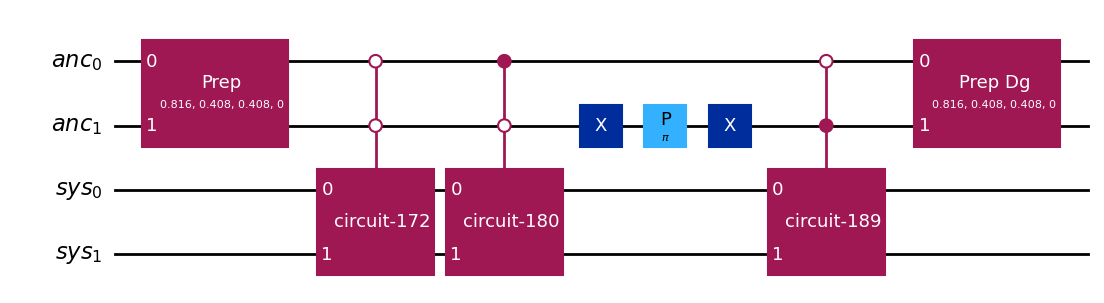

In [2]:
# 1. Define A and |x>
A = np.array([
    [1, 0, 0, -0.5],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [-0.5, 0, 0, 1]
], dtype=float)

x = np.array([0.6, 0.8, 0, 0], dtype=complex)
expected_output = A @ x

# 2. Pauli decomposition
pauli_split = SparsePauliOp.from_operator(A)
coeffs = pauli_split.coeffs 
alpha = np.sum(np.abs(coeffs))

L = len(coeffs)
num_ancilla = max(1, int(np.ceil(np.log2(L))))  # Ensure at least 1 ancilla
num_system = int(np.ceil(np.log2(A.shape[0])))

print(f"Number of Pauli terms: {L}")
print(f"Ancilla qubits: {num_ancilla}")
print(f"System qubits: {num_system}")

qr_anc = QuantumRegister(num_ancilla, 'anc')
qr_sys = QuantumRegister(num_system, 'sys')
qc = QuantumCircuit(qr_anc, qr_sys)

# 3. PREP: Magnitudes only
prep_vec = np.zeros(2**num_ancilla)
prep_vec[:L] = np.sqrt(np.abs(coeffs) / alpha)
prep_gate = StatePreparation(prep_vec, label='Prep')
qc.append(prep_gate, qr_anc)

# 4. SELECT: Controlled Paulis + Phase Absorption
for i, (pauli, c) in enumerate(zip(pauli_split.paulis, coeffs)):
    phase_angle = np.angle(c)
    binary_idx = format(i, f'0{num_ancilla}b')
    
    # Create a small circuit for this Pauli operation
    pauli_circ = QuantumCircuit(num_system)
    pauli_circ.append(pauli.to_instruction(), range(num_system))
    
    # Create controlled version
    ctrl_pauli = pauli_circ.to_gate().control(
        num_ctrl_qubits=num_ancilla, 
        ctrl_state=binary_idx
    )
    
    # Apply to full register
    qc.append(ctrl_pauli, [*qr_anc, *qr_sys])
    
    # Handle phase if necessary
    if not np.isclose(phase_angle, 0):
        # Apply phase correction
        phase_circ = QuantumCircuit(num_ancilla)
        
        # Target the specific binary state
        for bit_idx, char in enumerate(reversed(binary_idx)):
            if char == '0':
                phase_circ.x(bit_idx)
        
        # Global phase on ancilla
        phase_circ.p(phase_angle, num_ancilla-1)  # Apply phase to one qubit
        
        # Undo flips
        for bit_idx, char in enumerate(reversed(binary_idx)):
            if char == '0':
                phase_circ.x(bit_idx)
        
        qc.compose(phase_circ, qubits=qr_anc, inplace=True)

# 5. UNPREP: Identical mirror of PREP
qc.append(prep_gate.inverse(), qr_anc)

# 6. Simulate and post-select
full_init = Statevector.from_label('0' * num_ancilla).expand(Statevector(x))
final_sv = full_init.evolve(qc)

# Post-selection: pick entries where ancilla is |0...0>
stride = 2**num_ancilla
res_vector = final_sv.data[0::stride] * alpha

print("\nLCU Result: ", np.round(np.real_if_close(res_vector), 4))
print("Classical:  ", np.round(np.real_if_close(expected_output), 4))
print("Difference: ", np.linalg.norm(res_vector - expected_output))

display(qc.draw('mpl'))

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import StatePreparation
from qiskit.circuit import Gate

# 1. Define A and |x>
A = np.array([
    [1, 0, 0, -0.5],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [-0.5, 0, 0, 1]
], dtype=float)

x = np.array([0.6, 0.8, 0, 0], dtype=complex)
expected_output = A @ x

# 2. Pauli decomposition
pauli_split = SparsePauliOp.from_operator(A)
coeffs = pauli_split.coeffs
alpha = np.sum(np.abs(coeffs))

L = len(coeffs)
num_ancilla = int(np.ceil(np.log2(L)))
num_system = int(np.ceil(np.log2(A.shape[0])))

qr_anc = QuantumRegister(num_ancilla, 'a')
qr_sys = QuantumRegister(num_system, 's')
qc = QuantumCircuit(qr_anc, qr_sys)

# 3. PREP - magnitudes ONLY (no phases here!)
prep_vec = np.sqrt(np.abs(coeffs) / alpha)
prep_vec_padded = np.pad(prep_vec, (0, 2**num_ancilla - L))
qc.append(StatePreparation(prep_vec_padded, label='Prep'), qr_anc)

# 4. SELECT with phase-modified Paulis
for i, (pauli, c) in enumerate(zip(pauli_split.paulis, coeffs)):
    # Get the phase of this coefficient
    phase = np.angle(c)
    
    # Create Pauli gate and multiply by the phase
    pauli_gate = pauli.to_instruction()
    
    # If there's a non-zero phase, we need to apply it
    if not np.isclose(phase, 0):
        # Create a circuit with the Pauli and a global phase
        pauli_circ = QuantumCircuit(num_system, global_phase=phase, name='PhaseCorrect')
        pauli_circ.append(pauli_gate, range(num_system))
        pauli_gate = pauli_circ.to_gate()
    
    # Make it controlled
    ctrl_gate = pauli_gate.control(
        num_ancilla,
        ctrl_state=format(i, f'0{num_ancilla}b')
    )
    qc.append(ctrl_gate, [*qr_anc, *qr_sys])

# 5. UNPREP
qc.append(StatePreparation(prep_vec_padded).inverse(), qr_anc)

# 6. Simulate
full_initial_state = Statevector.from_label('0' * num_ancilla).expand(Statevector(x))
final_statevector = full_initial_state.evolve(qc)

# Post-select on ancilla = |0>
stride = 2**num_ancilla
res_vector = final_statevector.data[0::stride] * alpha

print("Circuit:  ", np.round(np.real_if_close(res_vector), 4))
print("Classical:", np.round(np.real_if_close(expected_output), 4))
print("Error:    ", np.linalg.norm(res_vector - expected_output))

display(qc.draw('mpl'))